In [1]:
!pip install pytorch-msssim

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
FOLDER = pathlib.Path('/content/drive/My Drive/Climatehack/jatin/')

import sys
sys.path.append(str(FOLDER))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# custom
import loss_utils

In [3]:
p = FOLDER / 'data_random_15.npz'
res = np.load(p)

times = res['times']
# x = res['x']
# x_osgb = res['x_osgb']
# y = res['y']
# y_osgb = res['y_osgb']
data = res['data']


In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [5]:
valid_is = []
for i in range(len(times) - 36):
  if (times[i + 36] - times[i]) / np.timedelta64(1, 'm') == 180:
    valid_is.append(i)

In [27]:
# make better choices for these
MEAN = 190.
STD = 100.

class SimpleDataset(Dataset):
    def __init__(self, data, valid_is, random_state):
        self.data = data
        self.valid_is = valid_is
        self.random_state = random_state
        self.generator = np.random.RandomState(random_state)
        
    def __getitem__(self, index):
        true_idx = self.valid_is[index]
        xslice, yslice = self.get_crop_idxs()
        imgs = torch.FloatTensor(self.data[true_idx : true_idx + 36, yslice, xslice])
        imgs = (imgs - MEAN) / STD

        ximg_first = imgs[0]
        # compute image diffs
        imgs = imgs - ximg_first
        x = imgs[:12, :, :]
        y = imgs[12:,32:96,32:96]
        return x, y, ximg_first
    
    def __len__(self):
        return len(self.valid_is)


    def get_crop_idxs(self):
      rand_x = self.generator.randint(550, 950 - 128)
      rand_y = self.generator.randint(375, 700 - 128)
      
      yslice = slice(rand_y, rand_y + 128)
      xslice = slice(rand_x, rand_x + 128)
      
      return xslice, yslice

In [28]:
RANDOM_SEED = 7
BATCH_SIZE = 64
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

train_ds = SimpleDataset(data, valid_is, random_state=RANDOM_SEED)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
x, y, ximg_first = train_ds[0]

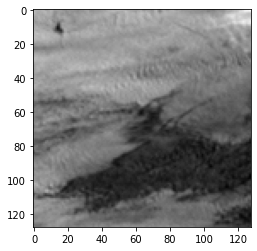

In [30]:
plt.imshow((x[1] + ximg_first) * STD + MEAN, cmap='gray')

In [32]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.fc = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
        )
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        # src = [batch size, 12, 128, 128]
        # this flatten pixels to be [batch_size, 12, 128*128]
        src = src.view(src.shape[0], src.shape[1], -1)
        embedded = self.fc(src)
        
        #embedded = [batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.fc_in = nn.Sequential(
            nn.Linear(output_dim, emb_dim),
            nn.ReLU(),
        )
                
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first=True)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size, 1, 64, 64]
        #hidden = [batch size, n layers * n directions, hid dim]
        #cell = [batch size, n layers * n directions, hid dim]
    
        # n directions in the decoder is 1 in this case
        
        # flatten images
        input = input.reshape(input.shape[0], input.shape[1], -1)
        embedded = self.fc_in(input)
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [batch size, hid dim * n directions]
        #hidden = [batch size, n layers * n directions, hid dim]
        #cell = [batch size, n layers * n directions, hid dim]
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, srcs, trgs, teacher_forcing_ratio = 0.5):
        
        #srcs = [batch size, 12, 128, 128]
        #trgs = [batch_size, 24, 64, 64]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trgs.shape[1]
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trgs.shape).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(srcs)
        
        #first input to the decoder is the last image in the hour
        # shape: (batch_size, 1, 64, 64)
        input = srcs[:,-1,32:96,32:96]
        input = torch.unsqueeze(input, 1)
        
        for t in range(24):
            output, hidden, cell = self.decoder(input, hidden, cell)
            # images of shape (batch_size, 64, 64)
            output = output.view(output.shape[0], trgs.shape[2], trgs.shape[3])
            outputs[:,t,:,:] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = np.random.random() < teacher_forcing_ratio
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted image
            input = trgs[:,t,:,:] if teacher_force else output
            input = torch.unsqueeze(input, 1)
        
        return outputs

In [33]:
INPUT_DIM = 128*128
OUTPUT_DIM = 64*64
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

In [34]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (fc): Sequential(
      (0): Linear(in_features=16384, out_features=256, bias=True)
      (1): ReLU()
    )
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (fc_in): Sequential(
      (0): Linear(in_features=4096, out_features=256, bias=True)
      (1): ReLU()
    )
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=4096, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,701,056 trainable parameters


In [36]:
optimizer = optim.Adam(model.parameters())
criterion = loss_utils.MS_SSIMLoss(channels=24)

In [62]:
def train_epoch(model, dl, optimizer, criterion):
  model.train()

  epoch_loss = 0
  pbar = tqdm.notebook.tqdm(dl)
  for i, (srcs, trgs, imgs_first) in enumerate(pbar):
      optimizer.zero_grad()
      
      srcs = srcs.to(DEVICE)
      trgs = trgs.to(DEVICE)
      output = model(srcs, trgs, teacher_forcing_ratio=0.0)

      # renormalize prediction
      middle_imgs_first = imgs_first[:, 32:96, 32:96]
      # this makes the middle image of shape (batch_size, 1, 64, 64)
      middle_imgs_first = torch.unsqueeze(middle_imgs_first, 1).to(DEVICE)
      norm_output = (output + middle_imgs_first) * STD + MEAN
      norm_trgs = (trgs + middle_imgs_first) * STD + MEAN
      
      # trgs, output shape: [batch size, 24, 64, 64]        
      loss = criterion(norm_output, norm_trgs)
      
      loss.backward()
      
      # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
      
      optimizer.step()
      
      epoch_loss += loss.item()
      if i % 1 == 0:
        l = round(epoch_loss / (i + 1), 4)
        pbar.set_description(f'MS-SSIM Loss: {l}')


def test_epoch(model, dl, criterion):
  model.eval()

  epoch_loss = 0
  pbar = tqdm.notebook.tqdm(dl)
  for i, (srcs, trgs, imgs_first) in enumerate(pbar):    
      srcs = srcs.to(DEVICE)
      trgs = trgs.to(DEVICE)    
      output = model(srcs, trgs, teacher_forcing_ratio=0.0)

      # renormalize prediction
      middle_imgs_first = imgs_first[:, 32:96, 32:96]
      # this makes the middle image of shape (batch_size, 1, 64, 64)
      middle_imgs_first = torch.unsqueeze(middle_imgs_first, 1).to(DEVICE)
      norm_output = (output + middle_imgs_first) * STD + MEAN
      norm_trgs = (trgs + middle_imgs_first) * STD + MEAN
      
      # trgs, output shape: [batch size, 24, 64, 64]        
      loss = criterion(norm_output, norm_trgs)
      
      epoch_loss += loss.item()
      if i % 1 == 0:
        l = round(epoch_loss / (i + 1), 4)
        pbar.set_description(f'Test MS-SSIM Loss: {l}')

In [63]:
EPOCHS = 20

for i in range(EPOCHS):
  print(f"Epoch {i + 1}")
  train_epoch(model, train_dl, optimizer, criterion)
  test_epoch(model, train_dl, criterion)

Epoch 1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [73]:
def predict(model, srcs):
    batch_size = srcs.shape[0]
        
    #tensor to store decoder outputs
    outputs = torch.zeros(batch_size, 24, 64, 64).to(DEVICE)
    
    #last hidden state of the encoder is used as the initial hidden state of the decoder
    hidden, cell = model.encoder(srcs)
    
    #first input to the decoder is the last image in the hour
    # shape: (batch_size, 1, 64, 64)
    input = srcs[:,-1,32:96,32:96]
    input = torch.unsqueeze(input, 1)

    for t in range(24):
        output, hidden, cell = model.decoder(input, hidden, cell)
        # images of shape (batch_size, 64, 64)
        output = output.view(batch_size, 64, 64)
        outputs[:,t,:,:] = output
        
        input = output
        input = torch.unsqueeze(input, 1)
    
    snorm_outputs = outputs * STD + MEAN    
    return snorm_outputs

In [70]:
def get_mssim(y, x):
    if len(y.shape) == 2:
        # we need to specify a number of channels. This sets it to 1 and calls the function again
        return get_mssim(torch.unsqueeze(y, 0), torch.unsqueeze(x, 0))
    # allow for the first index to be the batch
    assert len(y.shape) in [3, 4]
    channel_idx = 0 if len(y.shape) == 3 else 1
    mssim_loss = loss_utils.MS_SSIMLoss(channels=y.shape[channel_idx])
    if len(y.shape) == 3:
      yd = torch.unsqueeze(y, 0) # /255 * (MAX - MIN) + MIN
      xd = torch.unsqueeze(x, 0) # /255 * (MAX - MIN) + MIN
    else:
      yd = y
      xd = x
    return 1.0 - mssim_loss(
        yd,
        xd
    )

In [74]:
scores = []
for srcs, trgs in tqdm.notebook.tqdm(train_dl):
  srcs = srcs.to(DEVICE)
  trgs = trgs.to(DEVICE) * STD + MEAN
  preds = predict(model, srcs)
  s = get_mssim(preds, trgs)
  scores.append(s)


  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: ignored

In [72]:
scores

[tensor(0.9927, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9933, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9948, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9927, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9923, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9924, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9920, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9940, device='cuda:0', grad_fn=<RsubBackward1>)]

In [69]:
torch.save(model.state_dict(), FOLDER / 'simple_rnn_rand_15.pt')